<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/baseline_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-comp

In [2]:
!gdown https://drive.google.com/uc?id=1A8IdrqgEjRhvg9KoV6dopo5GirTKO3aj
!gdown https://drive.google.com/uc?id=1SCxtUqlGEzYCfCbHUREFf5UqoM1uWDBK
!gdown https://drive.google.com/uc?id=1Zh4mCpgQReE4E0sAjiFXwSV6Y7lc77fO
!gdown https://drive.google.com/uc?id=19jT2ZTb6oj6sFERkl5AT3qQExxN3D5cK

Downloading...
From: https://drive.google.com/uc?id=1A8IdrqgEjRhvg9KoV6dopo5GirTKO3aj
To: /content/sns_val.zip
100% 34.8M/34.8M [00:00<00:00, 195MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1SCxtUqlGEzYCfCbHUREFf5UqoM1uWDBK
To: /content/sns_train.zip
100% 278M/278M [00:00<00:00, 329MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Zh4mCpgQReE4E0sAjiFXwSV6Y7lc77fO
To: /content/train.csv
100% 2.24M/2.24M [00:00<00:00, 185MB/s]
Downloading...
From: https://drive.google.com/uc?id=19jT2ZTb6oj6sFERkl5AT3qQExxN3D5cK
To: /content/test.json
100% 417k/417k [00:00<00:00, 36.3MB/s]


In [3]:
!unzip -uq "/content/sns_train.zip" -d "/content/sns_data"
!unzip -uq "/content/sns_val.zip" -d "/content/sns_data"

In [4]:
!pip install transformers

In [5]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

import tensorflow as tf
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertForSequenceClassification   #BERT
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification   #RoBerta
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import TFGPT2LMHeadModel

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [6]:
train_df = pd.read_csv("/content/train.csv")

In [7]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9]+", " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    #sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [9]:
train_df["conversation"] = train_df["conversation"].apply(preprocess_sentence)
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 1억만 보내 예 선생님...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [10]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)

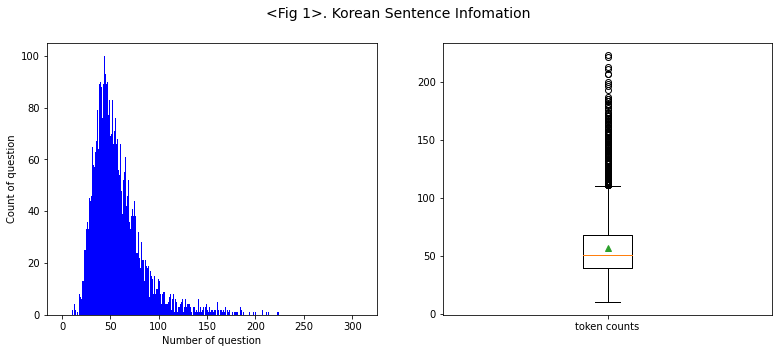

=========================================< Sentence Info >==========================================
길이 최대:     223
길이 최소:      10
길이 평균:     57.330
길이 표준편차:  27.040

 25/100분위:   40.000
 50/100분위:   51.000
 75/100분위:   68.000
 MAX/100분위: 110.000
 IQR:  28.000


In [11]:
sentence_counts = [len(text.split()) for text in train_df["conversation"]]

show_sentence_length(sentence_counts, "<Fig 1>. Korean Sentence Infomation", [0, 310])

In [12]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv',
 '/content/sns_data/content/sns_csv_train/일과직업.csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv']

In [13]:
'''
df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])
'''

'\ndf_all = pd.DataFrame()\nfor i in files:\n    df = pd.read_csv(i)\n    df_all = pd.concat([df_all, df])\n'

In [14]:

df_all = pd.DataFrame()
df_1 = pd.read_csv(files[0])
#df_2 = pd.read_csv(files[4])
df_all = pd.concat([df_all, df_1])
#df_all = pd.concat([df_all, df_2])
df_all


,0
0,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...
1,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...
2,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...
3,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...
4,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...
...,...
89995,전과하고 첫학기라 두근두근하겠구만\n외울게 더 많아질거 같아서 두렵긴함...\n근데...
89996,너네 시험은 언제봐 공지올라왔어?\n시험 갑자기 다음주로됨 다다음주인줄알았는데\n와...
89997,솔직히 별4개조 빼곤 다 그대로 하고싶지 않을까..? 어 잠만 너도 별4개잖아\n근...
89998,저때로부터 8년 지났네 2013에서 2021\nㅜㅜ세상에\nㅋㅋㅋㅋ세월 잘 간다.....


In [15]:
df_all["class"] = "일반 대화"

In [16]:
df_all.head()

,0,class
0,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...,일반 대화
1,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...,일반 대화
2,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...,일반 대화
3,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...,일반 대화
4,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...,일반 대화


In [17]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [18]:
df_all

,conversation,class
0,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...,일반 대화
1,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...,일반 대화
2,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...,일반 대화
3,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...,일반 대화
4,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...,일반 대화
...,...,...
89995,전과하고 첫학기라 두근두근하겠구만\n외울게 더 많아질거 같아서 두렵긴함...\n근데...,일반 대화
89996,너네 시험은 언제봐 공지올라왔어?\n시험 갑자기 다음주로됨 다다음주인줄알았는데\n와...,일반 대화
89997,솔직히 별4개조 빼곤 다 그대로 하고싶지 않을까..? 어 잠만 너도 별4개잖아\n근...,일반 대화
89998,저때로부터 8년 지났네 2013에서 2021\nㅜㅜ세상에\nㅋㅋㅋㅋ세월 잘 간다.....,일반 대화


In [19]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,#@이름#이~~~~~ 잘 지냉~~~??\n옹 잘지내고있어 잘지내고 회계1급 너무 어...
1,일반 대화,#@시스템#사진#\n이거밖에 없어? 자료 더없어?\n#@시스템#동영상#\n동영상 ...
2,일반 대화,수업듣구이써?\n수업와써헤헤\n잘해씨\n#@이름#는\n난 수업전에 책사러 왔는데 내...
3,일반 대화,느그 교수는 집값 안 줘? 박사는 줫다며\n그쪽은 돈마늠 ㅋㅋㅋ\n여긴 아녀?\n총...
4,일반 대화,아 나 또 막막하네 어떻게써야될지 그때 에피소드를 말했덩 것 같은데..\nㅜㅜ할수잇...
...,...,...
89995,일반 대화,전과하고 첫학기라 두근두근하겠구만\n외울게 더 많아질거 같아서 두렵긴함...\n근데...
89996,일반 대화,너네 시험은 언제봐 공지올라왔어?\n시험 갑자기 다음주로됨 다다음주인줄알았는데\n와...
89997,일반 대화,솔직히 별4개조 빼곤 다 그대로 하고싶지 않을까..? 어 잠만 너도 별4개잖아\n근...
89998,일반 대화,저때로부터 8년 지났네 2013에서 2021\nㅜㅜ세상에\nㅋㅋㅋㅋ세월 잘 간다.....


In [20]:
df_train2 = df_all.sample(n = 4000, random_state = 5)

In [21]:
df_train2["conversation"] = df_train2["conversation"].apply(preprocess_sentence)
df_train2

,class,conversation
6674,일반 대화,자격증 나오는데 문제는 사립학교 가기 힘들다는거지 나중에 얘기하자 예옙 나 남자친구...
49738,일반 대화,니이번주시험 아니가 마쥼 공부하고있나 800넘어야지 나 수업둥 어 쉅중이가 문제 다...
6981,일반 대화,힝구 그럼 언제 내려와앙 언니 시험 개망해서 못간당 앗 무슨 시험 영어시험 아앗 이모티콘
13306,일반 대화,어제 밤에 보내주신 데이터가 필터링 적용된 것인가요 일단 연결성 단계로 넘어가기 전...
1643,일반 대화,그럴걸여 그때 선거때도 저런거 많았는데 막상 까보니 민주당 압승이었자나요 진짜 문 ...
...,...,...
31997,일반 대화,시스템 기타 시스템 기타 저 분 지옥의 길로 걸어들어가려고 하네 왜요오 대학원 간대...
38364,일반 대화,아 빨리 시험끝나라아아아아 에에으으으으엑 일주일지나면 이틀남아 언제 끝나 금요일까지...
36759,일반 대화,시스템 사진 이거 함 만 풀어봥 급한건 아님 집가서해도됨 시스템 사진 저거 문제 잘...
13902,일반 대화,선형대수학 머야 왜캐 열심히살아 기타 이름 는 얼마전에 수리통계 그대로야 암튼 밧는...


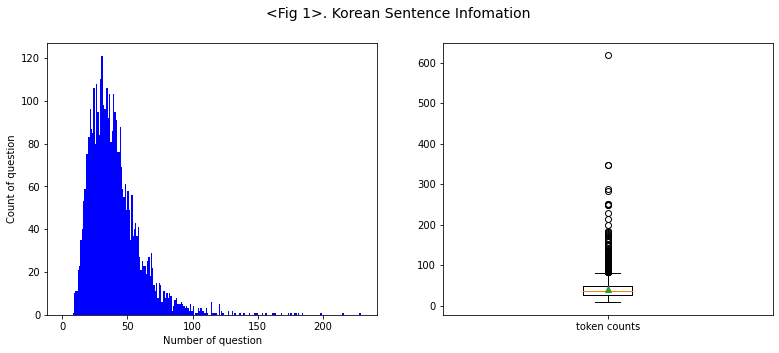

=========================================< Sentence Info >==========================================
길이 최대:     618
길이 최소:       8
길이 평균:     40.530
길이 표준편차:  25.286

 25/100분위:   26.000
 50/100분위:   36.000
 75/100분위:   48.250
 MAX/100분위:  81.625
 IQR:  22.250


In [22]:
sentence_counts_2 = [len(text.split()) for text in df_train2["conversation"]]

show_sentence_length(sentence_counts_2, "<Fig 1>. Korean Sentence Infomation", [0, 230])

In [23]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1.0,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3.0,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
31997,NaN,일반 대화,시스템 기타 시스템 기타 저 분 지옥의 길로 걸어들어가려고 하네 왜요오 대학원 간대...
38364,NaN,일반 대화,아 빨리 시험끝나라아아아아 에에으으으으엑 일주일지나면 이틀남아 언제 끝나 금요일까지...
36759,NaN,일반 대화,시스템 사진 이거 함 만 풀어봥 급한건 아님 집가서해도됨 시스템 사진 저거 문제 잘...
13902,NaN,일반 대화,선형대수학 머야 왜캐 열심히살아 기타 이름 는 얼마전에 수리통계 그대로야 암튼 밧는...


In [24]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...
31997,일반 대화,시스템 기타 시스템 기타 저 분 지옥의 길로 걸어들어가려고 하네 왜요오 대학원 간대...
38364,일반 대화,아 빨리 시험끝나라아아아아 에에으으으으엑 일주일지나면 이틀남아 언제 끝나 금요일까지...
36759,일반 대화,시스템 사진 이거 함 만 풀어봥 급한건 아님 집가서해도됨 시스템 사진 저거 문제 잘...
13902,일반 대화,선형대수학 머야 왜캐 열심히살아 기타 이름 는 얼마전에 수리통계 그대로야 암튼 밧는...


In [25]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,직장 내 괴롭힘 대화,어제 길동 사원님이랑 둘이서 회사에서 배달 시켜 먹었다면서요 아 네 같이 해야 할 ...
1,일반 대화,나 인강 20일부터 들어가기로 했는데 이모티콘 우리 그럼 시간 나눠야하나 예야스 우...
2,일반 대화,눕는다 아멀랑 하 하 언니 이게 기타 이런느낌 처음이야 완벽이 없는듯 어 그치 어 ...
3,일반 대화,그거 카피해줘 내가 보내주거 아아 안그래도 오늘 내가 그 영상 보여드렷는데 다른애가...
4,협박 대화,어이 아가씨 담배하나만 줘봐 담배이름을 말씀해주셔야죠 어떤거요 척하면 척이지 그것도...
...,...,...
7945,직장 내 괴롭힘 대화,지수씨 끝나고 우리 팀 회식할까요 다들 괜찮다는데 네 아 죄송합니다 오늘은 제가 약...
7946,일반 대화,이름 이름 는 저널클럽간거아냐 이름 언니가 오전에 웅마장 그런거가타 저널클럽이랬징 ...
7947,일반 대화,오빠 아빠꺼 문화센터 수강신청 먼저 도와줄꼬지 옹옹 켜놓거 기다리는중 학교수강신청하...
7948,직장 내 괴롭힘 대화,어우 김선생 좀봐 머리를 하고왔는데도 얼굴이 저 꼬라지네 못봐주겠다 진짜 저 인간은...


In [26]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(df_train, "conversation", 100)

In [27]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df_train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

df_train["class"] = bucket_class
df_train.head()

,class,conversation
0,2,어제 길동 사원님이랑 둘이서 회사에서 배달 시켜 먹었다면서요 아 네 같이 해야 할 ...
1,4,나 인강 20일부터 들어가기로 했는데 이모티콘 우리 그럼 시간 나눠야하나 예야스 우...
2,4,눕는다 아멀랑 하 하 언니 이게 기타 이런느낌 처음이야 완벽이 없는듯 어 그치 어 ...
3,4,그거 카피해줘 내가 보내주거 아아 안그래도 오늘 내가 그 영상 보여드렷는데 다른애가...
4,0,어이 아가씨 담배하나만 줘봐 담배이름을 말씀해주셔야죠 어떤거요 척하면 척이지 그것도...


In [28]:
X = df_train["conversation"].to_list()
Y = df_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 7155
y_train 개수 : 7155
x_val 개수 : 397
y_val 개수 : 397
x_test 개수 : 398
y_test 개수 : 398
훈련 데이터 레이블 비율 확인 : Counter({4: 3600, 3: 985, 1: 883, 2: 881, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({4: 200, 3: 54, 1: 49, 2: 49, 0: 45})
테스트 데이터 레이블 비율 확인 : Counter({4: 200, 3: 55, 2: 49, 1: 49, 0: 45})


In [29]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base", use_fast=True)

In [30]:

train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

In [31]:
x_train[0]

'살기 어려워 애있어서 함부로는 못말하겠는데 애교육도 잘해야되는데 빡세네 말같지도 않은 법이지 솔직히 이번 법 시스템이 애기들을 보호하지 않았던 것도 아니고 피해자가 청와대 청원 좀 흘리고 뉴스나와서 즙짜면 법 생기는게 현대국가라 보기 어려운듯 조선시대때 임금님 앞에 찾아가서 신문고 치고서 질질 짜면 사안 바이 사안으로 해결해주던거랑 다를바가 없는데 애이름따서법엄청많던데 청원하면 다만들어줌 즙짜기 마스크 단단히 끼고 손소독 계속하셔요 민식이법 개정으로보험사에서 전화가 왔다 숙지하라고 대박이넴 민식이법 진짜 말도 안되는 일이지 내용이 도대체 뭐길래 시스템 검색 이유불문하고 사망하면 100 프로 운전자과실이네'

In [32]:
for key in train_encodings:
  print(f"{key} : {train_encodings[key][1]}")

input_ids : [2, 1248, 1545, 2116, 1793, 3042, 2170, 16357, 2558, 8705, 4905, 2247, 2173, 30812, 2558, 2052, 2411, 2470, 2147, 3788, 2052, 5399, 2279, 2379, 4574, 6396, 18361, 3193, 5432, 3066, 2088, 1893, 3149, 2051, 2100, 2173, 1535, 5399, 6233, 2119, 1644, 2052, 2636, 2227, 2112, 4224, 1388, 2170, 2068, 2211, 2073, 4167, 5218, 2073, 2180, 2246, 2227, 2173, 3748, 2316, 2067, 2379, 3635, 2154, 3656, 2471, 2182, 1443, 4143, 2097, 2173, 1344, 5399, 1378, 12803, 2119, 3822, 3820, 2370, 4795, 5399, 2154, 864, 2207, 2052, 2015, 2119, 19521, 13575, 641, 3042, 2170, 2130, 2104, 2112, 641, 3042, 24094, 28179, 2100, 2678, 2495, 2178, 13964, 9379, 2765, 2227, 2299, 6230, 1545, 2558, 30812, 2179, 2147, 3788, 2073, 5218, 2073, 2471, 2182, 873, 2170, 3635, 2116, 1556, 14367, 2180, 1535, 2227, 2173, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:


train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), 
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), 
                                                  y_val))

In [34]:
num_labels = max(df_train["class"]) + 1
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", 
                                                        num_labels=num_labels, 
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
#bert_model.summary()
#kbert_model.summary()
#robert_model.summary()

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)


#kbert_model.fit(
#    kbert_train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
#    validation_data=kbert_val_dataset.shuffle(1000).batch(16),
#    callbacks = [callback_earlystop]
#)

#robert_model.fit(
#    robert_train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
#    validation_data=robert_val_dataset.shuffle(1000).batch(16),
#    callbacks = [callback_earlystop]
#)

In [37]:
model.fit(
    train_dataset.shuffle(1000).batch(8), epochs=1, batch_size=8,
    validation_data=val_dataset.shuffle(1000).batch(8),
    callbacks = [callback_earlystop]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


895/895 [==============================] - 534s 575ms/step - loss: 0.3195 - accuracy: 0.8945 - val_loss: 0.3119 - val_accuracy: 0.9068


In [38]:

model_path = "./model/fine-tuned-klue-robert-base"

model.save_pretrained(model_path)

tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-robert-base/tokenizer_config.json',
 './model/fine-tuned-klue-robert-base/special_tokens_map.json',
 './model/fine-tuned-klue-robert-base/vocab.txt',
 './model/fine-tuned-klue-robert-base/added_tokens.json',
 './model/fine-tuned-klue-robert-base/tokenizer.json')

In [39]:
# Load Fine-tuning model
model_path = "./model/fine-tuned-klue-robert-base"

loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)


text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue-robert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue-robert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [40]:

predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]


    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 398/398 [03:33<00:00,  1.86it/s]


In [41]:

y_pred = [int(label[-1]) for label in predicted_label_list]

y_true = y_test

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.62      0.74        45
           1       0.95      0.82      0.88        49
           2       0.85      0.90      0.87        49
           3       0.63      0.89      0.74        55
           4       1.00      0.97      0.99       200

    accuracy                           0.89       398
   macro avg       0.87      0.84      0.84       398
weighted avg       0.91      0.89      0.90       398



In [42]:

false_list = []



for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [43]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
8,야 민식아 너 몇달전에 빌린 내 돈 좀 다시 돌려줘야겠다 내가 급해서 말이야 뭐 갑...,0,1
53,중국 왜저러냐 김치도 중국꺼라고 우긴다네 아 그거봤어 진짜 왜저래 몰라 이해가 안되...,4,3
59,여기 희수야 하나 둘 내가 분명 삼만원 모아오라고 안했어 아니 그게 계속 모았는데 ...,3,1
61,받은글 춘해보건대 이름 총장입니다 저도 가정의학과 전문의인데요 음 코로나 바이러스 ...,4,3
92,똑바로 안할꺼야 지금 며칠이 지났는데 죄송합니다 그게 수행하다 방해꾼이 나타나서 그...,0,3
95,야 얘 때려봐 어떻게 제가 후임을 때릴 수가 있습니까 야 이렇게 때려보라고오 크헉 ...,2,3
103,니가 먼저 끼어들었자나 지금 누구보러 니라고 지칭하십니까 이새끼가 인성있는척하네 니...,0,3
109,너지 뭐가 내가 전직장에서 불미스러운 일에 엮여서 회사 여기로 옮긴거말이야 그게왜 ...,0,2
123,아줌마 손에 든거 뭐에요 장바구니인데요 아니 장바구니인건 아는데 뭐 들었어요 오늘 ...,1,3
125,야 쫄다구 너 자세가 그게 모야 왜 그러십니까 왜 왜 이게 죽고싶나 죄송합니다 이게...,0,3


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_

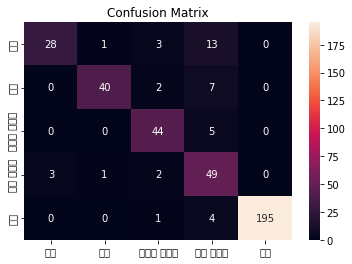

In [44]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [45]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,28,1,3,13,0
갈취,0,40,2,7,0
직장내 괴롭힘,0,0,44,5,0
기타 괴롭힘,3,1,2,49,0
일반,0,0,1,4,195


In [46]:
pip install transformers-interpret

In [47]:
"""
일단!!!
미리 만들어둔 모델들을 불러와야 합니다.
 
위의 Huggingface 모델에서 생성하고 저장 한 위치를 model과 tokenizer에 지정해주면 Auto기능 이 자동으로 해당
자료를 감지하여 가져옵니다. (신기합니다.)

"""
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer
#모델 불러오기 
model =  AutoModelForSequenceClassification.from_pretrained("./model/fine-tuned-klue-robert-base", from_tf=True) 
tokenizer = AutoTokenizer.from_pretrained("./model/fine-tuned-klue-robert-base")

#다중분류 설명자 생성
multiclass_explainer = SequenceClassificationExplainer(model=model, tokenizer=tokenizer)

All TF 2.0 model weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [48]:
fake_sample_text="""안녕하세요 저는 송영석 입니다. 자기소개를 시작하겠습니다. 저는 어릴적 강도질과 폭력을 일 삼았고 학창시절에는 나쁜 일들을 많이 저질렀습니다. 사람을 죽이고 싶었던 적이 많고 물건도 다 훔치고 빼았았습니다. 저는 죄를 반성하고 있습니다 """
general_sample_text = """김 부사장은 삼성전자가 현재 만들고 있는 반도체들의 구조 변화와 전망을 개괄적으로 설명했습니다. 삼성전자 주력인 D램, 낸드플래시 등 메모리 반도체부터 이미지센서, 시스템 반도체 구조와 미래까지 개괄적으로 조망한 점이 눈에 띕니다. """

In [49]:
word_attributions = multiclass_explainer(text=fake_sample_text)
html = multiclass_explainer.visualize()

In [50]:
# 점수가 높을 수록 해당 클래스가 나오게 하는데 기여를 많이한 부분이고 
# 점수가 낮을 수록 관여를 적게한 부분입니다.

word_attributions

[('[CLS]', 0.0),
 ('안녕', -0.030997725419430768),
 ('##하', 0.12442612034867115),
 ('##세요', 0.13279767653077465),
 ('저', 0.13684077636884323),
 ('##는', 0.21723558704962126),
 ('송영', 0.5193345921563999),
 ('##석', 0.18896149216208322),
 ('입니다', 0.175174542813212),
 ('.', 7.209442730963892e-05),
 ('자기', 0.6128995427957518),
 ('##소', 0.000813431249384138),
 ('##개', -0.04142780232324211),
 ('##를', 0.026504007122446913),
 ('시작', 0.043825172691953525),
 ('##하', 0.13841107689967933),
 ('##겠', 0.10006880563903256),
 ('##습', 0.06753823956473758),
 ('##니다', 0.13282467284105692),
 ('.', 0.06520971621423768),
 ('저', 0.07842657313864049),
 ('##는', 0.09858505017771146),
 ('어릴', 0.04520738949674759),
 ('##적', 0.036951173341959916),
 ('강도', -0.01926902298170473),
 ('##질', 0.038349905524125885),
 ('##과', 0.009458885620562853),
 ('폭력', -0.02969361573783016),
 ('##을', 0.07765553975997747),
 ('일', 0.06168259719182992),
 ('삼', 0.07539166080445708),
 ('##았', 0.009887231787645447),
 ('##고', 0.036181078760610316

In [51]:
#진짜 일반 대화 test
word_attributions = multiclass_explainer(text=general_sample_text)
html = multiclass_explainer.visualize()

In [52]:
word_attributions 

[('[CLS]', 0.0),
 ('김', -0.2556492614093586),
 ('부사장', -0.2845622167557699),
 ('##은', 0.0864391124089171),
 ('삼성전자', -0.10685030726929012),
 ('##가', 0.027901543172491237),
 ('현재', 0.029890861066949968),
 ('만들', -0.002555118087364622),
 ('##고', 0.018376204077287805),
 ('있', 0.017835136687744137),
 ('##는', -0.028923144117233863),
 ('반도체', -0.2128994800258003),
 ('##들', -0.10364961885155566),
 ('##의', -0.05652232969364209),
 ('구조', -0.05396737542429533),
 ('변화', 0.03603731623035749),
 ('##와', -0.034467347736267084),
 ('전망', -0.05057155291640352),
 ('##을', -0.14292837825867905),
 ('개', -0.043103142054664874),
 ('##괄', -0.0040782566933797275),
 ('##적으로', -0.12137614551948156),
 ('설명', -0.170299357333976),
 ('##했', -0.14623301600018332),
 ('##습', -0.13020623522325317),
 ('##니다', -0.16353820485124523),
 ('.', 0.10087430305961206),
 ('삼성전자', -0.09007868469170807),
 ('주력', -0.04840253605965194),
 ('##인', -0.019592225912708375),
 ('D', 0.04488204554402539),
 ('##램', -0.07990851247239726),
 (',',